Triggers turn on studies

In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import pickle
from multiprocessing import Pool
import matplotlib.pyplot as plt
from array import array
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise

In [3]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [4]:
import operator
ops = {'>': operator.gt, '<': operator.lt, '=': operator.eq}

In [5]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [6]:
cl = rt.TLine()
cl.SetLineColor(16)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [7]:
colors = {'data':rt.kBlack,
          'mu': rt.kAzure+1, 
          'tau': rt.kRed-4, 
          'Hc':rt.kGreen+1, 
          'Dstst': rt.kMagenta-7
         }

# Cuts declaration

In [8]:
# Needed to prevent different mixture in trigger path (in MC all of BPH are always ON but not in data)
trigger_cuts = [
 'trgMu_pt > 5',
 'trgMu_sigdxy > 1'
]

offline_cuts = [
 'mass_mumu < 3.174',
 'mass_mumu > 3.013',
 'mass_piK > 0.82',
 'mass_piK < 0.96',
 'mum_pt > 3.5',
 'mup_pt > 3.5',
 'Jpsi_pt > 7',
 'pval_mumu > 0.1',
 'mum_eta > -2.2',
 'mup_eta > -2.2',
 'mum_eta < 2.2',
 'mup_eta < 2.2',
 'cosT_Jpsi_PV > 0.95',
 'mum_dxy < 3',
 'mup_dxy < 3',
 'pval_piK > 0.1',
 'fabs(mass_piK - 0.892) < fabs(mass_piK_CPconj - 0.892)',
 'mass_KK > 1.035',
 'K_sigdxy_PV > 2',
 'pi_sigdxy_PV > 2',
 'sigdxy_vtxKst_PV > 5',
 'K_pt > 0.8',
 'pval_mumupiK > 0.1',
 'pi_pt > 0.8',
 'mass_mumupiK > 5.01',
 'mass_mumupiK < 5.56'
]

analysis_cuts = trigger_cuts + offline_cuts
analysis_cuts_str = ' && '.join(analysis_cuts)

# Load data

In [9]:
dataDir = '../data/cmsRD'
datasets_loc = {}
datasets_loc['dataC'] = glob(dataDir + '/ParkingBPH*/*2018C*B2JpsiKst_191128*')
datasets_loc['dataD'] = glob(dataDir + '/ParkingBPH*/*2018D*B2JpsiKst_191128*')
datasets_loc['MC'] = glob('../data/cmsMC_private/BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU0_10-2-3/ntuples_B2JpsiKst/out_CAND_*.root')

color_keys = colors.keys()
for i, (d, l) in enumerate(datasets_loc.iteritems()): 
    print d
    colors[d] = colors[color_keys[i]]
    for f in l[:6]:
        print f
    if len(l)>5:
        print '...'
    print

dataD
../data/cmsRD/ParkingBPH3/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_191128_CAND.root
../data/cmsRD/ParkingBPH2/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_191128_CAND.root
../data/cmsRD/ParkingBPH5/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_191128_CAND.root
../data/cmsRD/ParkingBPH4/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_191128_CAND.root
../data/cmsRD/ParkingBPH1/Run2018D-05May2019promptD-v1_RDntuplizer_B2JpsiKst_191128_CAND.root

MC
../data/cmsMC_private/BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU0_10-2-3/ntuples_B2JpsiKst/out_CAND_179.root
../data/cmsMC_private/BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU0_10-2-3/ntuples_B2JpsiKst/out_CAND_32.root
../data/cmsMC_private/BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_13TeV-pythia8_Hardbbbar_PTFilter5_0p0-evtgen_SVV_PU0_10-2-3/ntuples_B2JpsiKst/out_CAND_148.root
../data/cmsMC_private/BPH_Tag-Probe_B0_JpsiKst-mumuKpi-kp_1

In [10]:
lumi_tot, lumi_dic = getLumiReport(datasets_loc['dataC']+datasets_loc['dataD'])
CMS_lumi.integrated_lumi = lumi_tot

Lumi tot: 31.9 fb^-1
Lumi analyzed: 78.3%


### Create a skimmed tree

In [11]:
trgPath = ['Mu12_IP6', 'Mu7_IP4']
trgPath += ['Mu9_IP'+str(i) for i in [4,5,6]]
trgPath += ['Mu8_IP'+str(i) for i in [3,5,6]]
print trgPath

['Mu12_IP6', 'Mu7_IP4', 'Mu9_IP4', 'Mu9_IP5', 'Mu9_IP6', 'Mu8_IP3', 'Mu8_IP5', 'Mu8_IP6']


In [12]:
def skim_dset(inputs):
    dset_loc, tree = inputs
    output = []
    N_accepted_cand = []
    nMax = 1e11
    if dset_loc and tree is None:
        idx = dset_loc.find('BPH')
        part = dset_loc[idx+3]
        idx = dset_loc.find('Run2018')
        era = dset_loc[idx+7]
        f = rt.TFile(dset_loc, 'READ')
        aux_tree = f.Get('outA/Tevts')
    elif tree and dset_loc is None:
        aux_tree = tree
        aux = str(tree.GetTitle())
        era = aux.split('_')[0]
        part = aux.split('_')[1]
    else:
        return
    
    maxEntry=float(min(nMax, aux_tree.GetEntries()))
    for i_ev, ev in enumerate(aux_tree): 
        if i_ev >= nMax:
            break
        if i_ev % int(maxEntry*0.1) == 0:
            print era+part, ': {:.0f} %'.format(100*i_ev/maxEntry)
        N_acc = 0

        accept = True
        for c_str in trigger_cuts:
            aux = c_str.split(' ')
            if len(aux) != 3: raise
            x = getattr(ev, aux[0])
            if not ops[aux[1]](x, float(aux[2])):
                accept = False
        if not accept:
            continue

        for j in range(ev.pval_mumupiK.size()):
            accept = abs(ev.mass_piK[j] - 0.892) < abs(ev.mass_piK_CPconj[j] - 0.892)
            for c_str in offline_cuts:
                if c_str == 'fabs(mass_piK - 0.892) < fabs(mass_piK_CPconj - 0.892)': continue
                if not accept:
                    break
                aux = c_str.split(' ')
                if len(aux) != 3:
                    raise
                x = getattr(ev, aux[0])[j]
                accept = ops[aux[1]](x, float(aux[2]))
            if accept:
                N_acc += 1
                
                trg = [0]*len(trgPath)
                for it, t in enumerate(trgPath):
                    if hasattr(ev, 'trgMu_HLT_'+t):
                        if getattr(ev, 'trgMu_HLT_'+t):
                            trg[it] = 1

                evtinfo = (ev.mass_mumupiK[j], ev.B_mumupiK_pt[j], ev.B_mumupiK_eta[j])
                evtinfo += (ev.Jpsi_pt[j], ev.trgMu_pt, ev.trgMu_sigdxy)
                evtinfo += (ev.mum_pt[j], ev.mum_eta[j], ev.mum_isTrg[j])
                evtinfo += (ev.mup_pt[j], ev.mup_eta[j], ev.mup_isTrg[j])
                evtinfo += (ev.Kst_pt[j], ev.Kst_eta[j])
                evtinfo += tuple(trg)
                output.append(evtinfo)
        if N_acc > 0:
            N_accepted_cand.append(N_acc)
    print era+part, 'done'
    return [output, N_accepted_cand]

In [13]:
recreate = False
for k, loc_list in datasets_loc.iteritems():
    if recreate or not os.path.isfile('tmp/TriggerTurnOn_{}.root'.format(k)):
        if 'data' in k:
            inputs = [[l, None] for l in loc_list]
        else:
            inputs = []
            counter = 0
            for sublist in np.array_split(loc_list, 10):
                counter += 1
                t = rt.TChain('outA/Tevts', k + '_{}'.format(counter))
                for fn in sublist:
                    t.Add(fn)
                inputs.append([None, t])
                
        p = Pool(len(inputs))
        out = p.map(skim_dset, inputs)
            
        output = []
        N_accepted_cand = []
        for o, n in out:
            output += o
            N_accepted_cand += n

        print len(output)
        dic = {i:N_accepted_cand.count(i) for i in range(1, np.max(N_accepted_cand)+1)}
        print dic

        import root_numpy as rtnp
        leafs_names = ['mass_mumupiK', 'B_pt', 'B_eta', 
                       'Jpsi_pt', 
                       'trgMu_pt', 'trgMu_sigdxy', 
                       'mum_pt', 'mum_eta', 'mum_isTrg', 
                       'mup_eta', 'mup_pt', 'mup_isTrg', 
                       'Kst_pt', 'Kst_eta'
                      ]
        leafs_names += trgPath

        dtypes = []
        for n in leafs_names:
            dtypes.append((n, np.float32))

        a = np.array(output, dtype=dtypes)
        rtnp.array2root(a, 'tmp/TriggerTurnOn_{}.root'.format(k), treename='Tevts', mode='RECREATE')

D4 : 0 %
D3 : 0 %
D1 : 0 %
D2 : 0 %
D5 : 0 %
D3 : 10 %
D5 : 10 %
D1 : 10 %
D2 : 10 %
D4 : 10 %
D3 : 20 %
D5 : 20 %
D1 : 20 %
D2 : 20 %
D4 : 20 %
D3 : 30 %
D5 : 30 %
D1 : 30 %
D2 : 30 %
D4 : 30 %
D3 : 40 %
D5 : 40 %
D2 : 40 %
D1 : 40 %
D4 : 40 %
D3 : 50 %
D5 : 50 %
D2 : 50 %
D4 : 50 %
D1 : 50 %
D3 : 60 %
D5 : 60 %
D2 : 60 %
D1 : 60 %
D4 : 60 %
D3 : 70 %
D5 : 70 %
D2 : 70 %
D1 : 70 %
D4 : 70 %
D3 : 80 %
D5 : 80 %
D2 : 80 %
D1 : 80 %
D4 : 80 %
D3 : 90 %
D5 : 90 %
D2 : 90 %
D1 : 90 %
D4 : 90 %
D3 : 100 %
D3 done
D5 : 100 %
D5 done
D2 : 100 %
D2 done
D1 : 100 %
D1 done
D4 : 100 %
D4 done
100273
{1: 99836, 2: 217, 3: 1}
MC3 : 0 %
MC10 : 0 %
MC8 : 0 %
MC6 : 0 %
MC4 : 0 %
MC2 : 0 %
MC7 : 0 %
MC9 : 0 %
MC5 : 0 %
MC1 : 0 %
MC3 : 10 %
MC10 : 10 %
MC5 : 10 %
MC6 : 10 %
MC9 : 10 %
MC7 : 10 %
MC4 : 10 %
MC8 : 10 %
MC2 : 10 %
MC1 : 10 %
MC3 : 20 %
MC10 : 20 %
MC5 : 20 %
MC9 : 20 %
MC4 : 20 %
MC7 : 20 %
MC6 : 20 %
MC8 : 20 %
MC2 : 20 %
MC1 : 20 %
MC3 : 30 %
MC10 : 30 %
MC5 : 30 %
MC9 : 30 %
MC4 : 30 %

In [14]:
skimmed_tree = {}
for k in datasets_loc.keys():
    f = rt.TFile('tmp/TriggerTurnOn_{}.root'.format(k), 'READ')
    skimmed_tree[k] = f.Get('Tevts')
    donotdelete.append(f)

# $p_{T}$ turn on

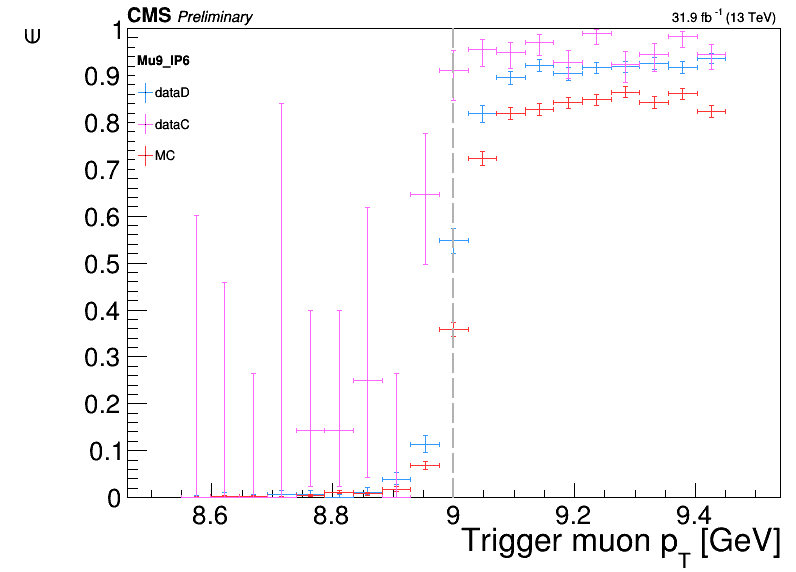

In [22]:
trg = trgPath[4]
ptthr_nom = float(trg.split('_')[0][2:])
# binning = array('d', [6.] + list(np.linspace(ptthr_nom*0.95, ptthr_nom*1.05, 20)) + list(np.linspace(ptthr_nom*1.05, 14, 30)) + [16] )
binning = array('d', list(np.linspace(ptthr_nom*0.95, ptthr_nom*1.05, 20)))

Teff = {}
leg = rt.TLegend(0.17, 0.7, 0.27, 0.92, trg)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

c = rt.TCanvas()
for k, t in skimmed_tree.iteritems():
    h_pass = create_TH1D(np.zeros(0), name='h_pass'+k+trg,
                        title='',
                        binning=binning
                       )
    t.Project('h_pass'+k+trg, 'trgMu_pt', trg)

    h_all = create_TH1D(np.zeros(0), name='h_all'+k+trg, binning=h_pass.binning, axis_title=['Trigger muon p_{T} [GeV]', '#epsilon'])
    t.Project('h_all'+k+trg, 'trgMu_pt', '')

    teff = rt.TEfficiency(h_pass, h_all)
    teff.SetLineColor(colors[k])
    leg.AddEntry(teff, k, 'lep')
    Teff[k] = teff

hlist = Teff.values()
c = drawOnCMSCanvas(CMS_lumi, hlist, 'same')
hlist[0].GetPaintedGraph().GetYaxis().SetRangeUser(0,1)
hlist[0].GetPaintedGraph().GetYaxis().SetTitle('#epsilon')
leg.Draw()
c.leg = leg
c.Teff = Teff
for i in [7,8,9,12]:
    cl.DrawLine(i, 0, i, 1)
c.Draw()
c.SetTitle(trg)

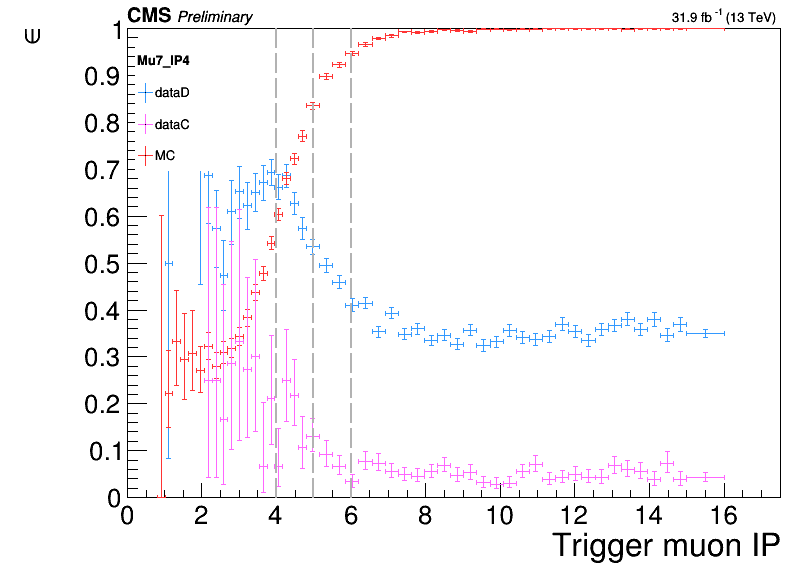

In [24]:
trg = trgPath[1]
ptthr_nom = float(trg.split('_')[1][2:])
binning = array('d', [0.1] + list(np.linspace(ptthr_nom*0.2, ptthr_nom*1.2, 20)) + list(np.linspace(ptthr_nom*1.2, 15, 30)) + [16] )

Teff = {}
leg = rt.TLegend(0.17, 0.7, 0.27, 0.92, trg)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)

c = rt.TCanvas()
for k, t in skimmed_tree.iteritems():
    h_pass = create_TH1D(np.zeros(0), name='h_pass'+k+trg,
                        title='',
                        axis_title=['Trigger muon IP', 'Events'],
                        binning=binning
                       )
    t.Project('h_pass'+k+trg, 'trgMu_sigdxy', trg)

    h_all = create_TH1D(np.zeros(0), name='h_all'+k+trg, binning=h_pass.binning, axis_title=['Trigger muon IP', '#epsilon'])
    t.Project('h_all'+k+trg, 'trgMu_sigdxy', '')

    teff = rt.TEfficiency(h_pass, h_all)
    teff.SetLineColor(colors[k])
    leg.AddEntry(teff, k, 'lep')
    Teff[k] = teff

hlist = Teff.values()
c = drawOnCMSCanvas(CMS_lumi, hlist, 'same')
hlist[0].GetPaintedGraph().GetYaxis().SetRangeUser(0,1)
leg.Draw()
c.leg = leg
c.Teff = Teff
for i in [4,5,6]:
    cl.DrawLine(i, 0, i, 1)
c.Draw()
c.SetTitle(trg)

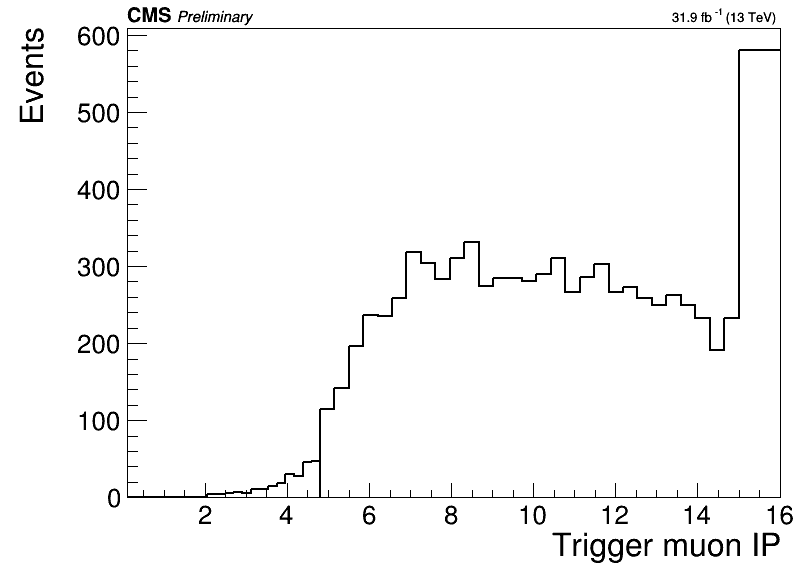

In [27]:
h = create_TH1D(np.zeros(0), name='h',
                        title='',
                        axis_title=['Trigger muon IP', 'Events'],
                        binning=binning
                       )
skimmed_tree['dataC'].Project('h', 'trgMu_sigdxy')
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.Draw()